In [1]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 8.3 MB/s eta 0:00:00


In [2]:
!pip install afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53430 sha256=f465bef85f6a392a6602225a6e20f849ec0095bbada5d2a25d5febda976a439e
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [3]:
pip install emosent-py


In [4]:
! pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 829.6 kB/s eta 0:00:00


In [5]:
#importamos librerias
from afinn import Afinn
import pandas as pd
import numpy as np
import emosent
from emosent import get_emoji_sentiment_rank_multiple
from emosent import get_emoji_sentiment_rank
import emoji
import re
import requests
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from wordcloud import WordCloud
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from dask.distributed import Client
import joblib
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from dask.distributed import Client

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
#conectamos al drive para subie nuestro dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#cargamos el dataset
df = pd.read_csv(r'/content/drive/MyDrive/datset proyecto final /df_concat_english.csv')

In [8]:
df.head()

,class,tweet_id,day,time,tweet,tweet_favorite_count,tweet_retweet_count,tweet_source,user_id,user_followers_count,user_friends_count,user_listed_count,user_statuses_count
0,ADHD,1547511137868169217,2022-07-14,09:19:41,"""@USER AAABDVSGJS NOO you're too kind 😭🥺 more ...",1,0,Twitter for Android,1276497310667673604,186,936,2,10598
1,ADHD,1541325761528872960,2022-06-27,07:41:12,"""wow! 🤩 two years here HTTPURL""",3,0,Twitter for Android,1276497310667673604,186,936,2,10598
2,ADHD,1527392373063315460,2022-05-19,20:54:53,"""nothing can compare to RK900 manboobies thoug...",2,0,Twitter for Android,1276497310667673604,186,936,2,10598
3,ADHD,1527392371352141825,2022-05-19,20:54:53,"""too bad his titties weren't bara sized huge a...",2,0,Twitter for Android,1276497310667673604,186,936,2,10598
4,ADHD,1527392369892524032,2022-05-19,20:54:53,"""ended up paying more than what was initially ...",2,0,Twitter for Android,1276497310667673604,186,936,2,10598


In [9]:
# fucion para generar etiquetas diagnosticado y no diagnosticado
def asignar_salida_diagnostica(clase):
    if clase == 'CONTROL':
        return 'no diagnosticado'
    else:
        return 'diagnosticado'

In [10]:
# creamos una columna de salida diagnosticada
df['salida_diagnostica'] = df['class'].apply(asignar_salida_diagnostica)

In [11]:
df= df[['class','tweet','user_id','salida_diagnostica']]

In [12]:
df.head()

,class,tweet,user_id,salida_diagnostica
0,ADHD,"""@USER AAABDVSGJS NOO you're too kind 😭🥺 more ...",1276497310667673604,diagnosticado
1,ADHD,"""wow! 🤩 two years here HTTPURL""",1276497310667673604,diagnosticado
2,ADHD,"""nothing can compare to RK900 manboobies thoug...",1276497310667673604,diagnosticado
3,ADHD,"""too bad his titties weren't bara sized huge a...",1276497310667673604,diagnosticado
4,ADHD,"""ended up paying more than what was initially ...",1276497310667673604,diagnosticado


In [13]:
# separamos a un dataset con solo los diagnosticados
df_dig = df[df['salida_diagnostica'] == 'diagnosticado']
#Creamos dataset con el numero de twets por cada usuario
tweets_por_usuario = df_dig.groupby('user_id').size()
df_usuarios_dig = tweets_por_usuario.reset_index()
df_usuarios_dig.columns = ['user_id','tweets_por_usuario']
df_usuarios_dig


,user_id,tweets_por_usuario
0,627213,2782
1,799396,2173
2,2716031,2386
3,6043922,2455
4,6114252,2200
...,...,...
1538,1474076653454303237,2173
1539,1474470008004694017,114
1540,1475588099744878592,439
1541,1475652295635664900,20


array([[<Axes: title={'center': 'tweets_por_usuario'}>]], dtype=object)

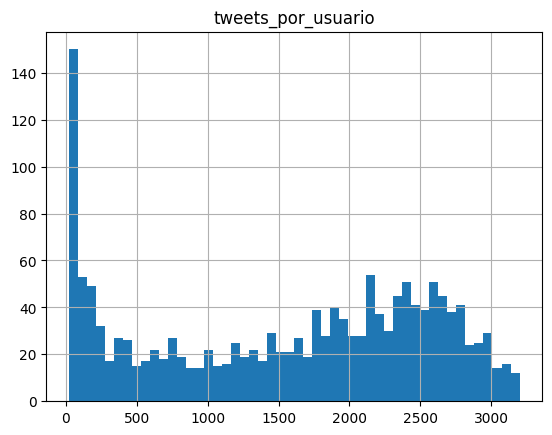

In [14]:
df_usuarios_dig.hist('tweets_por_usuario',bins=50)


In [15]:
df_usuarios_dig.describe()

,user_id,tweets_por_usuario
count,1.543000e+03,1543.000000
mean,7.131181e+17,1561.204148
std,6.075645e+17,989.109606
min,6.272130e+05,19.000000
25%,8.305773e+08,586.500000
50%,9.293926e+17,1764.000000
75%,1.296817e+18,2420.500000
max,1.476108e+18,3200.000000


In [16]:
#filtro el dataset y quito los usuarios que tengan mas de 2500 tweets e imprimo a cuantos tweets corresponde
df_prueba_solo75 = df_usuarios_dig[(df_usuarios_dig['tweets_por_usuario'] < 2500)]
num_tweets_dig_s75 =  sum(df_prueba_solo75['tweets_por_usuario'].values)
num_tweets_dig_s75

1480113

In [17]:
# separamos a un dataset con solo los no diagnosticados
df_control = df[df['salida_diagnostica'] == 'no diagnosticado']
#Creamos dataset con el numero de twets por cada usuario
tweets_por_usuario = df_control.groupby('user_id').size()
df_usuarios_contr = tweets_por_usuario.reset_index()
df_usuarios_contr.columns = ['user_id','tweets_por_usuario']
df_usuarios_contr

,user_id,tweets_por_usuario
0,800069,3075
1,2035621,3024
2,6045902,3043
3,6411892,2847
4,6620062,1637
...,...,...
1698,1349758763453079556,190
1699,1349760801683492866,795
1700,1349763435865792512,1384
1701,1349765420052475911,77


array([[<Axes: title={'center': 'tweets_por_usuario'}>]], dtype=object)

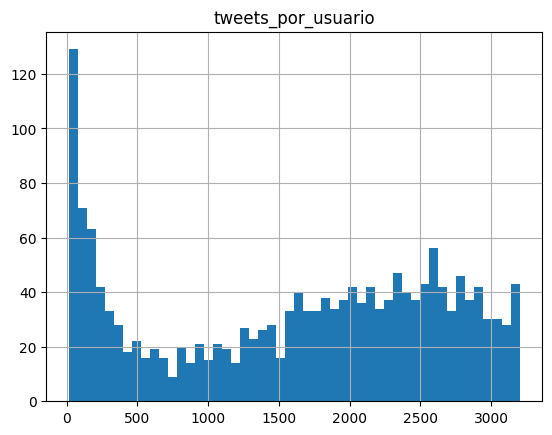

In [18]:
df_usuarios_contr.hist('tweets_por_usuario',bins=50)

In [19]:
df_usuarios_contr.describe()

,user_id,tweets_por_usuario
count,1.703000e+03,1703.000000
mean,5.909739e+17,1621.582501
std,5.735708e+17,1014.109973
min,8.000690e+05,15.000000
25%,4.702716e+08,594.500000
50%,7.733020e+17,1801.000000
75%,1.173476e+18,2503.500000
max,1.349792e+18,3200.000000


In [20]:
#filtro el dataset y quito los usuarios que tengan mas de 2500 tweets e imprimo a cuantos tweets corresponde
df_prueba_ctr_solo75 = df_usuarios_contr[(df_usuarios_contr['tweets_por_usuario'] < 2500)]
num_tweets_ctr_solo75 =sum(df_prueba_ctr_solo75['tweets_por_usuario'].values)
#imprimimos la cantidad de tweets luego de quitar en los 2 casos los usuarios que tengan mas de 2500 tweets
print(f'control : {num_tweets_ctr_solo75}')
print(f'enfermo : {num_tweets_dig_s75}' )

control : 1545774
enfermo : 1480113


In [21]:
#juntamos los dataset balanceados
df_usuarios_solo75 = pd.concat([df_prueba_ctr_solo75,df_prueba_solo75])
#del dataset original lo fitraremos user_id luego de quitarnos esos que tienen mas tweets
df_filtrado_solo75 =df[df['user_id'].isin(df_usuarios_solo75['user_id'])]

In [ ]:
df_filtrado_solo75.shape

(3025887, 4)

In [22]:
df_filtrado_solo75.to_csv('df_filtrado_solo75.csv', index=False)

In [23]:
df = pd.read_csv(r'/content/df_filtrado_solo75.csv')
df.duplicated().sum()

86397

In [24]:
df.drop_duplicates(inplace=True)

In [25]:
df.isna().sum()

class                 0
tweet                 0
user_id               0
salida_diagnostica    0
dtype: int64

In [26]:
# Filtrar el DataFrame original para excluir la clase 'CONTROL'
df_no_control = df[df['class'] != 'CONTROL']

# Contar el número de muestras por clase en el DataFrame filtrado
class_counts = df_no_control['class'].value_counts()

# Crear un DataFrame balanceado para la clase 'CONTROL' con una muestra de 1,000,000
df_balanced = df[df['class'] == 'CONTROL'].sample(1000000)

# Iterar sobre cada clase y su conteo
for class_, count in class_counts.items():
    if count > 200000:
        # Si la clase tiene más de 200,000 muestras, hacer un muestreo aleatorio de 200,000 muestras
        df_sample = df_no_control[df_no_control['class'] == class_].sample(200000, random_state=42)
    else:
        # Si no, tomar todas las muestras de esa clase
        df_sample = df_no_control[df_no_control['class'] == class_]

    # Concatenar las muestras al DataFrame balanceado
    df_balanced = pd.concat([df_balanced, df_sample], ignore_index=True)

# Ahora df_balanced contiene hasta 200,000 muestras de cada clase, si están disponibles

In [27]:
df_balanced['class'].value_counts()

class
CONTROL            1000000
ADHD                200000
DEPRESSION          200000
AUTISM              160749
ANXIETY             122460
BIPOLAR             121927
PTSD                110670
OCD                  71779
EATING DISORDER      23138
SCHIZOPHRENIA        16116
Name: count, dtype: int64

In [28]:
df_balanced['salida_diagnostica'].value_counts()

salida_diagnostica
diagnosticado       1026839
no diagnosticado    1000000
Name: count, dtype: int64

In [29]:
df_balanced = df_balanced[['user_id','tweet', 'salida_diagnostica']]

In [30]:
# Agrupar por usuario y diagnosticado, y luego concatenar los tweets en bloques de n tweets
def group_tweets(series):
    return [' '.join(series.iloc[i:i + 20]) for i in range(0, len(series), 20)]

# Agrupa y luego aplica la función
grouped = df_balanced.groupby(['user_id', 'salida_diagnostica'])['tweet'].apply(group_tweets).reset_index()
grouped = grouped.explode('tweet').reset_index(drop=True)

In [31]:
#terminamos con un dataset de 100,000 filas cada una con bloques de 20 tweets aprox balanceado
grouped['salida_diagnostica'].value_counts()

salida_diagnostica
diagnosticado       51918
no diagnosticado    50591
Name: count, dtype: int64

In [32]:
def detectar_emojis_completo(tweet):
    sentiment_score_total = 0  # Iniciar el puntaje total en cero

    # Iterar sobre cada carácter en el tweet
    for char in tweet:
        # Verificar si el carácter es un emoji
        if char in emoji.EMOJI_DATA:  # Usar EMOJI_DATA para verificar si es un emoji
            # Obtener el valor de sentiment_score del emoji
            emoji_sentiment_rank = get_emoji_sentiment_rank(char)
            if emoji_sentiment_rank:
                sentiment_score = emoji_sentiment_rank['sentiment_score']
                sentiment_score_total += sentiment_score  # Sumar el puntaje al total

    return sentiment_score_total

In [33]:
grouped['Emojis_Sentimentscore'] = grouped['tweet'].apply(detectar_emojis_completo)

In [34]:
def clean_emoji(text):
    return emoji.replace_emoji(text, replace='')
grouped['clean_tweet'] = grouped['tweet'].apply(clean_emoji)

In [35]:
# Lista de palabras y frases de interés
first_person_terms = ['I',"i'm", 'me', 'myself', 'my', 'mine', 'to me', 'for me', 'I feel', 'I think', 'I believe', 'I am', ]

# Función para contar ocurrencias de las palabras/frases
def count_first_person_terms(text):
    count = 0
    for term in first_person_terms:
        count += text.lower().count(term.lower())
    return count

# Función para calcular la normalización por longitud del tweet
def normalize_by_length(text):
    words = text.split()  # Dividir el texto en palabras
    return len(words)

# Aplicar las funciones y calcular la proporción normalizada
grouped['first_person_count'] = grouped['tweet'].apply(count_first_person_terms)
grouped['tweet_length'] = grouped['tweet'].apply(normalize_by_length)
grouped['egocentrism_score'] = grouped['first_person_count'] / grouped['tweet_length']

grouped.head()

,user_id,salida_diagnostica,tweet,Emojis_Sentimentscore,clean_tweet,first_person_count,tweet_length,egocentrism_score
0,799396,diagnosticado,"""It's a cigar kind of Saturday night."" ""@USER ...",2.618,"""It's a cigar kind of Saturday night."" ""@USER ...",169,463,0.365011
1,799396,diagnosticado,"""@USER @USER Sparkle toilet! You have do the s...",3.949,"""@USER @USER Sparkle toilet! You have do the s...",163,440,0.370455
2,799396,diagnosticado,"""@USER Aaaahhh! I look forward to seeing you!!...",8.370,"""@USER Aaaahhh! I look forward to seeing you!!...",122,329,0.370821
3,799396,diagnosticado,"""I just today marks one month that I've offici...",7.519,"""I just today marks one month that I've offici...",105,338,0.310651
4,799396,diagnosticado,"""@USER Oooooh you're a terrible influence and ...",5.537,"""@USER Oooooh you're a terrible influence and ...",159,497,0.319920


In [36]:
afinn = Afinn()
# Calcula la puntuación de sentimiento para cada texto
grouped['sentiment_score'] = grouped['clean_tweet'].apply(afinn.score)

In [37]:
def excl_score(tweet):
    if isinstance(tweet, str):
        num_exclamaciones = tweet.count('!')
        return num_exclamaciones / len(tweet) if len(tweet) > 0 else 0
    else:
        return 0


grouped['exclamation'] = grouped['tweet'].apply(excl_score)

In [38]:
def interrogation_score(tweet):
    if isinstance(tweet, str):
        num_interrogaciones = tweet.count('?')
        return num_interrogaciones / len(tweet) if len(tweet) > 0 else 0
    else:
        return 0


grouped['question'] = grouped['tweet'].apply(interrogation_score)

In [39]:
# Función para calcular el puntaje basado en menciones
def mention_score(tweet):
    if isinstance(tweet, str):
        mentions = len(re.findall(r'@', tweet))
        return mentions / len(tweet) if len(tweet) > 0 else 0
    else:
        return 0

grouped['mention'] = grouped['tweet'].apply(mention_score)

In [40]:
# Función para calcular el puntaje basado en risas
def laugh_score(tweet):
    if isinstance(tweet, str):
        laughs = len(re.findall(r'\b(?:ha|he|ja|je|hi){2,}\b', tweet, re.IGNORECASE))
        return laughs / len(tweet) if len(tweet) > 0 else 0
    else:
        return 0

grouped['laugh'] = grouped['tweet'].apply(laugh_score)

In [41]:
grouped

,user_id,salida_diagnostica,tweet,Emojis_Sentimentscore,clean_tweet,first_person_count,tweet_length,egocentrism_score,sentiment_score,exclamation,question,mention,laugh
0,799396,diagnosticado,"""It's a cigar kind of Saturday night."" ""@USER ...",2.618,"""It's a cigar kind of Saturday night."" ""@USER ...",169,463,0.365011,35.0,0.005064,0.000779,0.005454,0.0
1,799396,diagnosticado,"""@USER @USER Sparkle toilet! You have do the s...",3.949,"""@USER @USER Sparkle toilet! You have do the s...",163,440,0.370455,62.0,0.004115,0.000000,0.004115,0.0
2,799396,diagnosticado,"""@USER Aaaahhh! I look forward to seeing you!!...",8.370,"""@USER Aaaahhh! I look forward to seeing you!!...",122,329,0.370821,52.0,0.008734,0.001638,0.007642,0.0
3,799396,diagnosticado,"""I just today marks one month that I've offici...",7.519,"""I just today marks one month that I've offici...",105,338,0.310651,43.0,0.010241,0.000512,0.008193,0.0
4,799396,diagnosticado,"""@USER Oooooh you're a terrible influence and ...",5.537,"""@USER Oooooh you're a terrible influence and ...",159,497,0.319920,60.0,0.004811,0.001110,0.004811,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102504,1476107652920918016,diagnosticado,"""Now Im about to get my ""after work beers"" @US...",0.909,"""Now Im about to get my ""after work beers"" @US...",116,319,0.363636,0.0,0.000000,0.000642,0.003209,0.0
102505,1476107652920918016,diagnosticado,"""I just wanna be a hot girl 2022 😩"" ""All Im sa...",-0.333,"""I just wanna be a hot girl 2022 "" ""All Im say...",84,205,0.409756,-11.0,0.000000,0.000000,0.002935,0.0
102506,1476107652920918016,diagnosticado,"""Some fucking TikTok guy reminded me that 3 do...",1.348,"""Some fucking TikTok guy reminded me that 3 do...",82,225,0.364444,-11.0,0.004440,0.002664,0.001776,0.0
102507,1476107652920918016,diagnosticado,"""Im really fucking starting my day off drinkin...",1.683,"""Im really fucking starting my day off drinkin...",87,227,0.383260,-10.0,0.002530,0.001686,0.002530,0.0


In [42]:
def preprocess(text):
    # Convertir el texto a minúsculas
    text = text.lower()
    # Eliminar URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Eliminar menciones de usuarios (@usuario)
    text = re.sub(r'@\w+','',text)
    # Eliminar hashtags (#hashtag)
    text = re.sub(r'#\w+','',text)
    # Eliminar caracteres no alfabéticos y dígitos
    text = re.sub(r'[^\w\s]|[\d]', ' ', text)
    # Eliminar espacios en blanco adicionales y espacios al principio y al final del texto
    text = re.sub(r'\s+',' ',text).strip()
    # Tokenizar el texto en palabras
    tokens = word_tokenize(text)
    # Eliminación de los acentos en las palabras
    tokens = [unidecode(token) for token in tokens]
    # Definir un conjunto de stopwords en inglés y convertir todas las palabras a minúsculas y sin acentos
    stop_w = set([unidecode(w) for w in stopwords.words('english')])
    # Eliminar las stopwords del texto
    tokens = [token for token in tokens if token not in stop_w]
    # Lematización de las palabras (convertirlas a su forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if len(token) >= 3]
    # Unir las palabras procesadas en una sola cadena de texto
    return ' '.join(tokens)

In [43]:
grouped['clean_tweet'] =  grouped['clean_tweet'].apply(preprocess)

In [ ]:
grouped

,user_id,salida_diagnostica,tweet,Emojis_Sentimentscore,first_person_count,tweet_length,egocentrism_score,clean_tweet,sentiment_score,question,exclamation,laugh,mention
0,799396,diagnosticado,"""It's a cigar kind of Saturday night."" ""@USER ...",2.618,169,463,0.365011,cigar kind saturday night medium telling truth...,35.0,1,1,0,1
1,799396,diagnosticado,"""@USER @USER Sparkle toilet! You have do the s...",3.949,163,440,0.370455,sparkle toilet shiniest business levi always d...,62.0,0,1,0,1
2,799396,diagnosticado,"""@USER Aaaahhh! I look forward to seeing you!!...",8.370,122,329,0.370821,aaaahhh look forward seeing yes stairwell home...,52.0,1,1,0,1
3,799396,diagnosticado,"""I just today marks one month that I've offici...",7.519,105,338,0.310651,today mark one month officially living oregon ...,43.0,1,1,0,1
4,799396,diagnosticado,"""@USER Oooooh you're a terrible influence and ...",5.537,159,497,0.319920,oooooh terrible influence love convince husban...,60.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102530,1476107652920918016,diagnosticado,"""Now Im about to get my ""after work beers"" @US...",0.909,116,319,0.363636,get work beer point surviving monster wtf wron...,0.0,1,0,0,1
102531,1476107652920918016,diagnosticado,"""I just wanna be a hot girl 2022 😩"" ""All Im sa...",-0.333,84,205,0.409756,wan hot girl saying kinda ghosting dont talk d...,-11.0,0,0,0,1
102532,1476107652920918016,diagnosticado,"""Some fucking TikTok guy reminded me that 3 do...",1.348,82,225,0.364444,fucking tiktok guy reminded door existed added...,-11.0,1,1,0,1
102533,1476107652920918016,diagnosticado,"""Im really fucking starting my day off drinkin...",1.683,87,227,0.383260,really fucking starting day drinking honestly ...,-10.0,1,1,0,1


In [44]:
print(grouped.isna().sum())

user_id                  0
salida_diagnostica       0
tweet                    0
Emojis_Sentimentscore    0
clean_tweet              0
first_person_count       0
tweet_length             0
egocentrism_score        0
sentiment_score          0
exclamation              0
question                 0
mention                  0
laugh                    0
dtype: int64


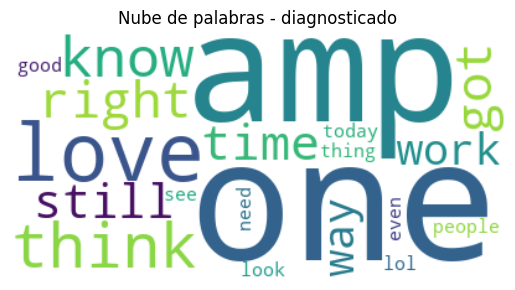

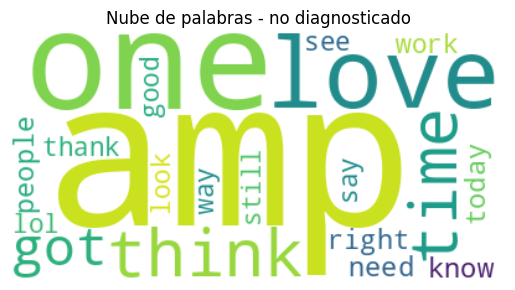

In [45]:
diagnosico_list = grouped.salida_diagnostica.unique()
for x in diagnosico_list:
  text_partido = ' '.join(grouped[grouped.salida_diagnostica==x]['clean_tweet'].tolist())
  wordcloud = WordCloud(background_color="white", max_words=20, contour_color="steelblue", collocations=True)
  wordcloud.generate(text_partido)
  # Mostrar la nube de palabras para cada partido
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(f"Nube de palabras - {x}")
  plt.axis("off")
  plt.show()

In [46]:
grouped['user_status'] = grouped['salida_diagnostica'].map({'diagnosticado': 1, 'no diagnosticado': 0})

In [47]:
grouped = grouped[['clean_tweet', 'Emojis_Sentimentscore','egocentrism_score', 'sentiment_score','question','exclamation','laugh','mention','user_status']]

In [ ]:
grouped.to_csv('/content/drive/MyDrive/df_twets_prueba_s75_for_xgboost_final.csv', index=False)

In [ ]:
y = grouped['user_status']  # Asegúrate de que df['label'] contiene las etiquetas adecuadas
X = grouped.drop(columns=['user_status'])

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Vectorizamos
vectorizer = TfidfVectorizer(ngram_range=(1,3))
X_train_tfidf = vectorizer.fit_transform(X_train['clean_tweet'])
X_test_tfidf = vectorizer.transform(X_test['clean_tweet'])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Escala las características de sentimiento
sentiment_features_train = X_train[['Emojis_Sentimentscore', 'egocentrism_score','sentiment_score','question','exclamation','laugh','mention']]
sentiment_features_test = X_test[['Emojis_Sentimentscore', 'egocentrism_score','sentiment_score']]
scaled_sentiment_features_train = scaler.fit_transform(sentiment_features_train)
scaled_sentiment_features_test = scaler.transform(sentiment_features_test)
# Si X_train_tfidf es una matriz dispersa, necesitas convertir las características escaladas a una matriz dispersa también, o convertir todo a denso

scaled_sentiment_features_sparse_train = csr_matrix(scaled_sentiment_features_train)
scaled_sentiment_features_sparse_test = csr_matrix(scaled_sentiment_features_test)
# Combinar las características TF-IDF con las características de sentimiento escaladas
X_combined_train = hstack([X_train_tfidf, scaled_sentiment_features_sparse_train])
X_combined_test = hstack([X_test_tfidf, scaled_sentiment_features_sparse_test])

In [ ]:
from sklearn.metrics import accuracy_score, make_scorer
# Definir el clasificador XGBoost
client = Client()
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')


with joblib.parallel_backend('dask'):
    xgb_clf.fit(X_combined_train, y_train)


predictions = xgb_clf.predict(X_combined_test)

print(classification_report(y_test, predictions))

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38209 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:41503
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:38209/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37201'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33971'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34453'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37799'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:32937', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:32937
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:35196
INFO:distributed.scheduler:Reg

              precision    recall  f1-score   support

           0       0.73      0.71      0.72     10118
           1       0.72      0.75      0.73     10389

    accuracy                           0.73     20507
   macro avg       0.73      0.73      0.73     20507
weighted avg       0.73      0.73      0.73     20507



In [ ]:

# Inicializar el cliente Dask
client = Client()

# Definir el clasificador XGBoost
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Definir distribuciones de parámetros
param_dist = {
    'n_estimators': np.arange(100, 500, 50),
    'learning_rate': np.logspace(-4, 0, 10),
    'max_depth': np.arange(2, 10, 1),
    'colsample_bytree': np.arange(0.2, 1, 0.1)
}

# Configurar el RandomizedSearchCV
rs_clf = RandomizedSearchCV(xgb_clf, param_dist, n_iter=25, scoring='accuracy', n_jobs=-1, cv=2, random_state=42)

# Ejecutar la búsqueda con backend de Dask
with joblib.parallel_backend('dask'):
    rs_clf.fit(X_combined_train, y_train)

# Ver los mejores parámetros encontrados y el mejor modelo
print('Mejores parámetros encontrados:\n', rs_clf.best_params_)
final_model = rs_clf.best_estimator_






/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36027 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:43683
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:36027/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34829'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42073'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45765'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45571'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45377', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45377
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:49184
INFO:distributed.scheduler:Reg

Mejores parámetros encontrados:
 {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.3593813663804626, 'colsample_bytree': 0.7000000000000002}


In [ ]:
# Predecir y evaluar el clasificador
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76     17323
           1       0.76      0.77      0.77     17516

    accuracy                           0.76     34839
   macro avg       0.76      0.76      0.76     34839
weighted avg       0.76      0.76      0.76     34839

